In [2]:
import brainbox
from one.api import ONE
from utils import download_glm_hmm, save_data_path, val_eid

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib.patches as mpatches

import phate
import scprep

In [3]:
# Loading up the cleaned data
data = pd.read_pickle('data/ephys_glm_frame_data.pkl')
data.shape

(29023, 31)

In [4]:
def count_max_prob_classes(frame_predictions):
    # Find the index of the max probability in each row
    max_indices = np.argmax(frame_predictions, axis=1)
    
    # Count occurrences of each index
    counts = np.bincount(max_indices, minlength=4)
    
    # Map counts to class names
    class_names = ["still", "move", "wheel_turn", "groom"]
    count_dict = {class_names[i]: counts[i] for i in range(4)}
    
    return count_dict

In [5]:
adf = pd.DataFrame(columns=["session", "trial_idx", "glm_hmm_state_1", "glm_hmm_state_2", "glm_hmm_state_3", "still", "move", "wheel_turn", "groom"])

for sess_id in val_eid:
    # Get the data for the session
    sess_data = data[data['session'] == sess_id]
    
    # for every trial of this session, get the frame predictions
    for i in range(len(sess_data)):
        # Get the data for this trial
        trial_data = sess_data.iloc[i]
        
        # Get the frame predictions
        frame_predictions = trial_data['frame_preds']

        # Count the number of occurrences of each class
        count_dict = count_max_prob_classes(frame_predictions)

        # get the 3 state glm_hmm_state model
        glm_hmm_state_model = trial_data['glm-hmm_3']

        # store them in the dataframe
        adf = pd.concat([adf, pd.DataFrame({
            "session": [sess_id],
            "trial_idx": [i],
            "glm_hmm_state_1": [glm_hmm_state_model[0]],
            "glm_hmm_state_2": [glm_hmm_state_model[1]],
            "glm_hmm_state_3": [glm_hmm_state_model[2]],
            **count_dict
        })])

In [15]:
# GLM-HMM state as labels
labels = adf[["glm_hmm_state_1", "glm_hmm_state_2", "glm_hmm_state_3"]].idxmax(axis=1)

# PHATE

In [6]:
phate_op = phate.PHATE(n_components=2)
data_phate = phate_op.fit_transform(adf[["still", "move", "wheel_turn", "groom"]].to_numpy())

Calculating PHATE...
  Running PHATE on 29023 observations and 4 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 1.52 seconds.
    Calculating affinities...


/home/rudra/.local/lib/python3.9/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 59332 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 0.55 seconds.
  Calculated graph and diffusion operator in 2.08 seconds.
  Calculating landmark operator...
    Calculating SVD...


/home/rudra/.local/lib/python3.9/site-packages/graphtools/graphs.py:454: RuntimeWarning: overflow encountered in power
  K.data = np.exp(-1 * np.power(K.data, self.decay))


    Calculated SVD in 1.73 seconds.
    Calculating KMeans...
    Calculated KMeans in 3.55 seconds.
  Calculated landmark operator in 5.84 seconds.
  Calculating optimal t...
    Automatically selected t = 31
  Calculated optimal t in 1.50 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.65 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 3.35 seconds.
Calculated PHATE in 13.43 seconds.


/home/rudra/.local/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Text(0.5, 1.0, 'PHATE of frame predictions colored by session')

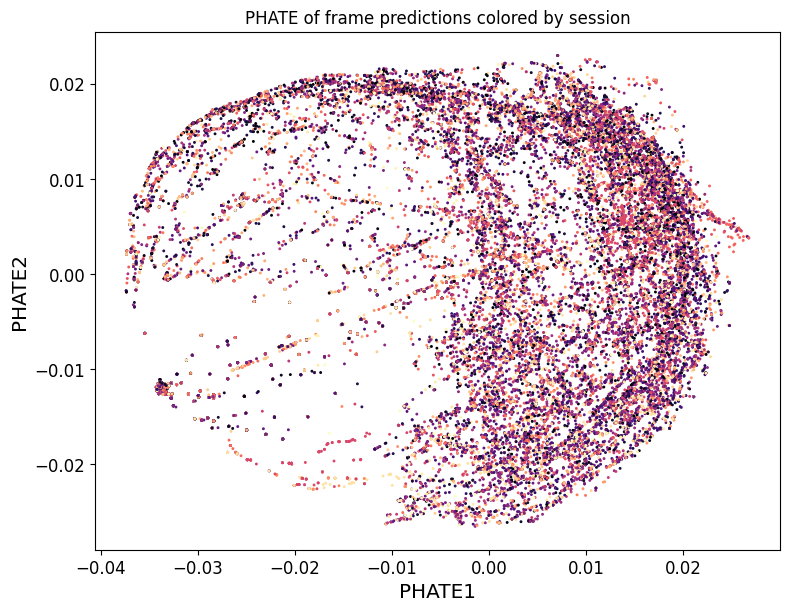

In [8]:
scprep.plot.scatter2d(
    data_phate, 
    c=adf['session'].to_numpy(), 
    figsize=(8,6), 
    cmap="magma",  
    label_prefix="PHATE", 
    legend=False)
plt.title("PHATE of frame predictions colored by session")

/home/rudra/.local/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Text(0.5, 1.0, 'PHATE of frame predictions colored by most likely glm-hmm state')

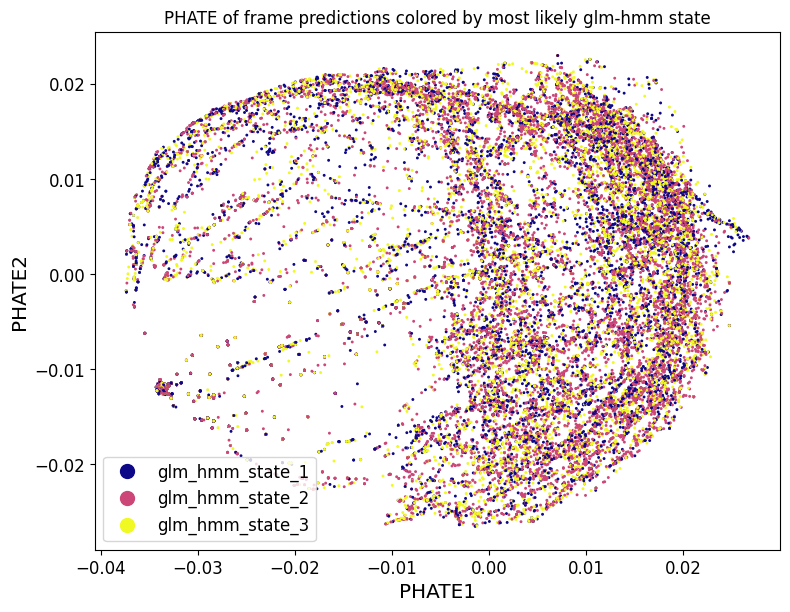

In [36]:
scprep.plot.scatter2d(
    data_phate, 
    c=labels, 
    figsize=(8,6),
    cmap="plasma", 
    label_prefix="PHATE", 
    legend=True,
    dpi=300,
    legend_loc="lower left",
    )
plt.title("PHATE of frame predictions colored by most likely glm-hmm state")

# MDS

In [52]:
# Due to performance issues, we will sub-sample the data
sub_sampled_data = adf[["still", "move", "wheel_turn", "groom"]].to_numpy()[::20, :]
sub_sampled_labels = labels.to_numpy()[::20]
sub_sampled_data.shape, sub_sampled_labels.shape

((1452, 4), (1452,))

In [ ]:
# similarly MDS
from sklearn.manifold import MDS

mds_op = MDS(n_components=2)
data_mds = mds_op.fit_transform(sub_sampled_data)

/home/rudra/.local/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Text(0.5, 1.0, 'MDS of frame predictions colored by most likely glm-hmm state\nNote: Embedded on sub-sampled 1:20 data for performance')

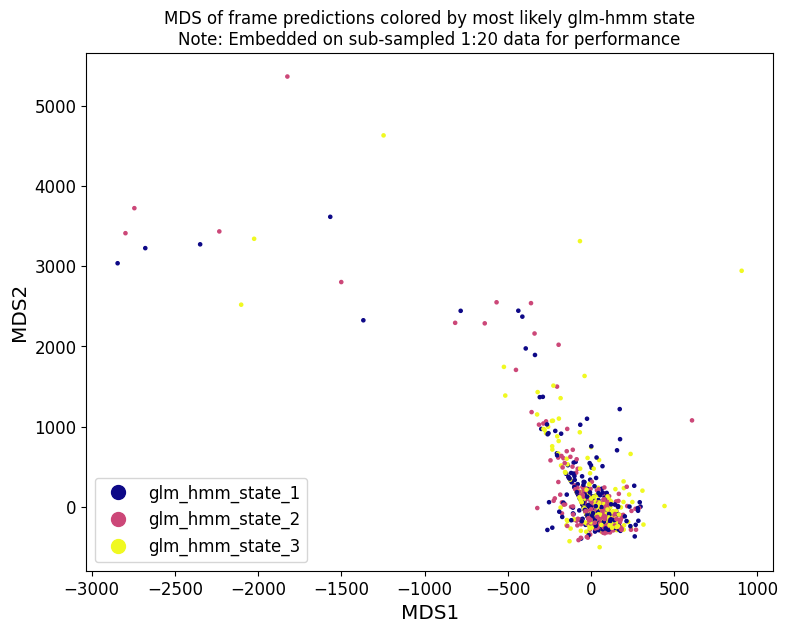

In [62]:
scprep.plot.scatter2d(
    data_mds, 
    c=sub_sampled_labels, 
    figsize=(8,6),
    cmap="plasma", 
    label_prefix="MDS", 
    legend=True,
    dpi=300,
    legend_loc="lower left",
    )
plt.title("MDS of frame predictions colored by most likely glm-hmm state\nNote: Embedded on sub-sampled 1:20 data for performance")

# PCA

/home/rudra/.local/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Text(0.5, 1.0, 'PCA of frame predictions colored by most likely glm-hmm state')

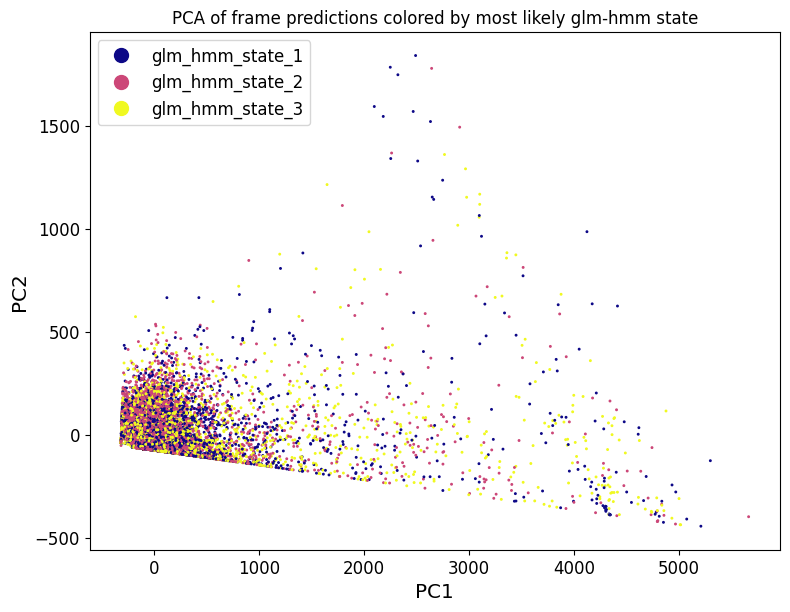

In [47]:

from sklearn.decomposition import PCA

pca_op = PCA(n_components=2)
data_pca = pca_op.fit_transform(adf[["still", "move", "wheel_turn", "groom"]].to_numpy())

scprep.plot.scatter2d(
    data_pca, 
    c=labels, 
    figsize=(8,6),
    cmap="plasma", 
    label_prefix="PC", 
    legend=True,
    dpi=300,
    legend_loc="upper left"
)
# set legend location
plt.title("PCA of frame predictions colored by most likely glm-hmm state")

# TSNE

In [48]:
# t-SNE
from sklearn.manifold import TSNE

tsne_op = TSNE(n_components=2)
data_tsne = tsne_op.fit_transform(adf[["still", "move", "wheel_turn", "groom"]].to_numpy())

/home/rudra/.local/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


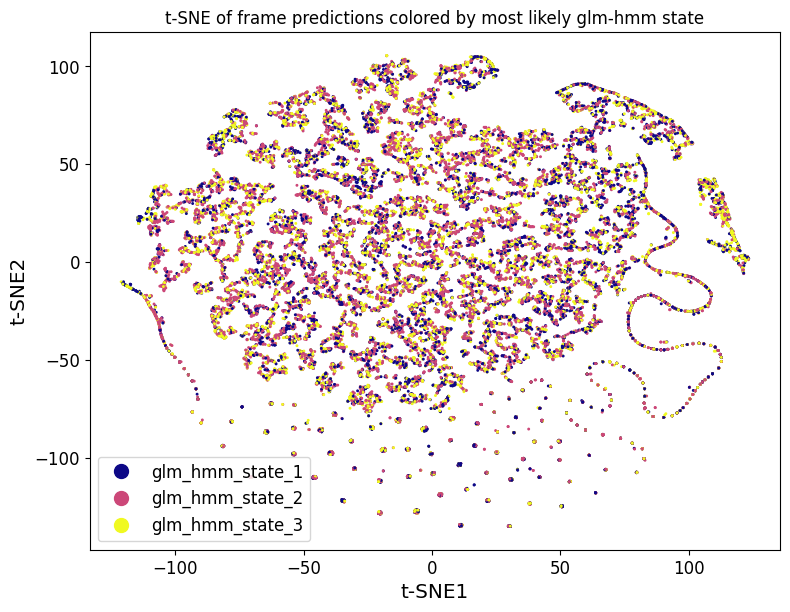

In [51]:
scprep.plot.scatter2d(
    data_tsne, 
    c=labels, 
    figsize=(8,6),
    cmap="plasma", 
    label_prefix="t-SNE", 
    legend=True,
    dpi=300,
    legend_loc="lower left"
)
plt.title("t-SNE of frame predictions colored by most likely glm-hmm state")
plt.show()

# UMAP

In [58]:
# Now umap
import umap

umap_op = umap.UMAP(n_components=2)
data_umap = umap_op.fit_transform(adf[["still", "move", "wheel_turn", "groom"]].to_numpy())

/home/rudra/miniconda3/envs/plab/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/rudra/miniconda3/envs/plab/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


/home/rudra/.local/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


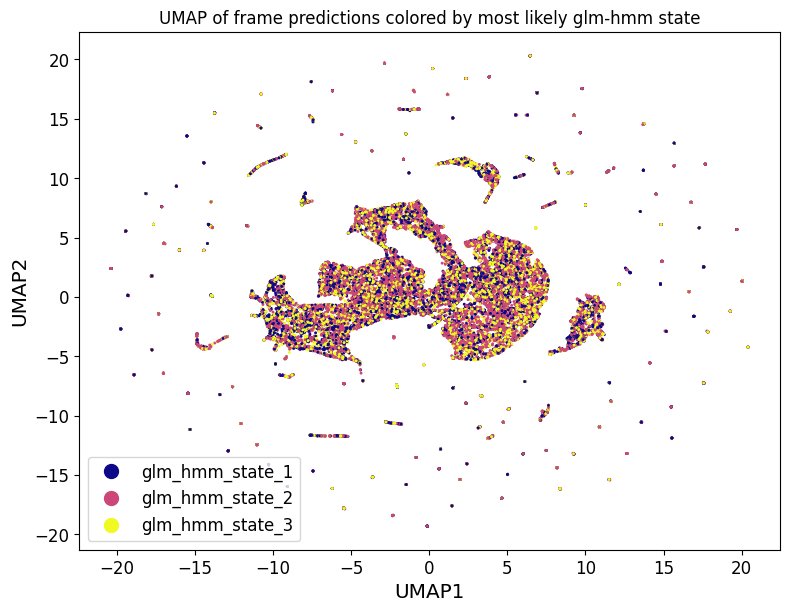

In [60]:
scprep.plot.scatter2d(
    data_umap, 
    c=labels, 
    figsize=(8,6),
    cmap="plasma", 
    label_prefix="UMAP", 
    legend=True,
    dpi=300,
    legend_loc="lower left"
)
plt.title("UMAP of frame predictions colored by most likely glm-hmm state")
plt.show()